In [6]:
___Author___='LumberJack Jyss'

In [7]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


In [8]:
print('Importing librairies...')
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,roc_curve,confusion_matrix,classification_report
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dense
from keras.utils import to_categorical
%matplotlib inline
print('Librairies imported')

Importing librairies...
Librairies imported


In [9]:
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
tf.logging.set_verbosity(tf.logging.ERROR)

In [10]:
df_1D = pd.read_csv('20190526 data prepared.csv')
df_1D = df_1D.iloc[:,1:]
df_1D = df_1D.dropna()
df_1D.reset_index(inplace=True,drop=True)

In [11]:
df_1D.isnull().sum().sum()

0

In [12]:
df_1D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6440 entries, 0 to 6439
Data columns (total 23 columns):
Date                  6440 non-null object
Varop_Spy             6440 non-null float64
Varhl_spy             6440 non-null float64
RSI                   6440 non-null float64
75 - RSI              6440 non-null float64
RSI - 25              6440 non-null float64
BBD_Delta_Up          6440 non-null float64
delta5_8              6440 non-null float64
delta8_10             6440 non-null float64
delta10_12            6440 non-null float64
delta12_15            6440 non-null float64
delta15_30            6440 non-null float64
delta30_35            6440 non-null float64
delta35_40            6440 non-null float64
delta40_45            6440 non-null float64
delta45_50            6440 non-null float64
Peaks                 6440 non-null int64
Valley                6440 non-null int64
delta_tsf             6440 non-null float64
Forcast Oscillator    6440 non-null float64
target_up         

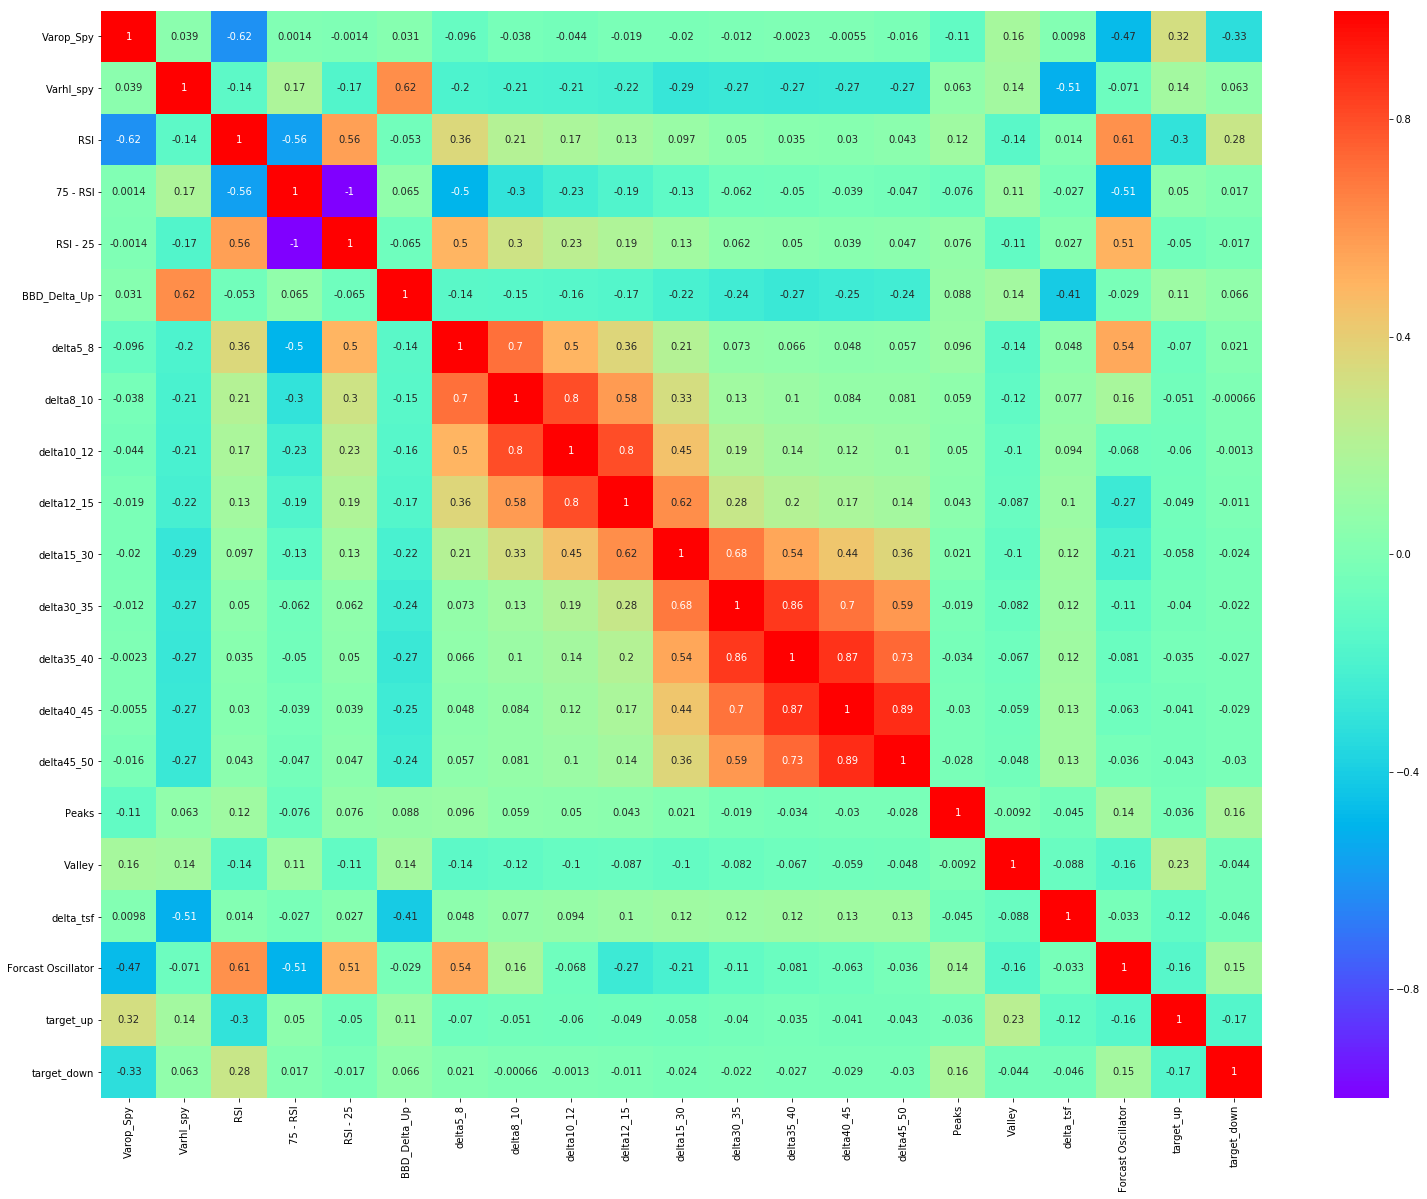

In [13]:
plt.figure(figsize=(26,20))
sns.heatmap(df_1D.iloc[:,:-1].corr(),annot=True,cmap='rainbow')
plt.show()

In [14]:
df_1D.shape

(6440, 23)

In [15]:
df_1D['target_up'].sum(),df_1D['target_down'].sum()

(798, 1101)

In [ ]:
delta = round(df_1D.shape[0])
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("# of periods : ",delta)
print('On 80% - 20% slash : ')
print('Bloc 1 : ',bloc1,' periods (',df_1D.iloc[bloc1,0],')\nBloc 2 :',bloc2,' periods (',df_1D.iloc[bloc2,0],')')
print('First period :',df_1D.iloc[0,0])
print('Last period :',df_1D.iloc[df_1D.shape[0]-1,0])


# of periods :  6440
On 80% - 20% slash : 
Bloc 1 :  5152  periods ( 20190321  17:30:00 )
Bloc 2 : 1288  periods ( 20180814  21:30:00 )
First period : 20180604  21:30:00
Last period : 20190531  21:45:00


In [ ]:
X = df_1D.iloc[:,1:-3]
#X = X.drop(['Peaks','Valley'],axis=1)
#X = X.drop(['75 - RSI','RSI - 25'],axis=1)
y_up = df_1D.iloc[:,-3].values
y_down = df_1D.iloc[:,-2].values

encoder = LabelEncoder()
encoder.fit(y_up)
y_up = encoder.transform(y_up)
encoder.fit(y_down)
y_down = encoder.transform(y_down)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6440 entries, 0 to 6439
Data columns (total 19 columns):
Varop_Spy             6440 non-null float64
Varhl_spy             6440 non-null float64
RSI                   6440 non-null float64
75 - RSI              6440 non-null float64
RSI - 25              6440 non-null float64
BBD_Delta_Up          6440 non-null float64
delta5_8              6440 non-null float64
delta8_10             6440 non-null float64
delta10_12            6440 non-null float64
delta12_15            6440 non-null float64
delta15_30            6440 non-null float64
delta30_35            6440 non-null float64
delta35_40            6440 non-null float64
delta40_45            6440 non-null float64
delta45_50            6440 non-null float64
Peaks                 6440 non-null int64
Valley                6440 non-null int64
delta_tsf             6440 non-null float64
Forcast Oscillator    6440 non-null float64
dtypes: float64(17), int64(2)
memory usage: 956.0 KB


In [ ]:
X.iloc[:5,[6,7]]

,delta5_8,delta8_10
0,0.57400,0.15900
1,0.65000,0.39900
2,0.63850,0.31950
3,0.43400,0.34200
4,0.46825,0.57175


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
#y_up = scaler.fit_transform(np.array(y_up).reshape(-1,1))
#y_down = scaler.fit_transform(np.array(y_down).reshape(-1,1))
y_up = np.array(y_up).reshape(-1,1)
y_down = np.array(y_down).reshape(-1,1)

In [ ]:
X[:5,[6,7]]

array([[0.51885542, 0.50190471],
       [0.52060674, 0.51192402],
       [0.52034174, 0.50860512],
       [0.51562932, 0.50954443],
       [0.51641856, 0.51913583]])

In [ ]:
Xtrain = X[:bloc1,:]
Xtest = X[bloc1:,:]
ytrain_up = y_up[:bloc1,:]
ytest_up = y_up[bloc1:,:]
ytrain_down = y_down[:bloc1,:]
ytest_down = y_down[bloc1:,:]

In [ ]:
Xtrain.shape,ytrain_up.shape,ytrain_down.shape,ytest_down.shape,ytest_up.shape

((5152, 19), (5152, 1), (5152, 1), (1288, 1), (1288, 1))

In [ ]:
Xtrain = Xtrain.reshape((Xtrain.shape[0],1,Xtrain.shape[1]))
Xtest = Xtest.reshape((Xtest.shape[0],1,Xtest.shape[1]))

ytrain_up = ytrain_up.reshape((ytrain_up.shape[0],1,ytrain_up.shape[1]))
ytest_up = ytest_up.reshape((ytest_up.shape[0],1,ytest_up.shape[1]))
ytrain_down = ytrain_down.reshape((ytrain_down.shape[0],1,ytrain_down.shape[1]))
ytest_down = ytest_down.reshape((ytest_down.shape[0],1,ytest_down.shape[1]))

Xtrain.shape,Xtest.shape, ytrain_up.shape , ytest_up.shape, ytrain_down.shape, ytest_down.shape

((5152, 1, 19),
 (1288, 1, 19),
 (5152, 1, 1),
 (1288, 1, 1),
 (5152, 1, 1),
 (1288, 1, 1))

In [ ]:
n_timesteps = Xtrain.shape[0]
print('Processing move_up')
model_up = Sequential()
model_up.add(LSTM(50, return_sequences=True))
model_up.add(TimeDistributed(Dense(1, activation='sigmoid')))
model_up.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_up.fit(Xtrain, ytrain_up, epochs=200, batch_size=32, verbose=0)
print('Processing move_down')
model_down = Sequential()
model_down.add(LSTM(50, return_sequences=True))
model_down.add(TimeDistributed(Dense(1, activation='sigmoid')))
model_down.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_down.fit(Xtrain, ytrain_down, epochs=200, batch_size=32, verbose=0)
print('Done')

Processing move_up
Processing move_down


In [ ]:
ytest_up = ytest_up.reshape(ytest_up.shape[0],ytest_up.shape[1])
ytest_down = ytest_down.reshape(ytest_down.shape[0],ytest_down.shape[1])

In [ ]:
bloc2

In [ ]:
a = 0
b = 0
for i in range(0, bloc2-1):
    if ytest_up[i] == yhat_up[i]:
        a += 1
    if ytest_up[i] == yhat_up[i] and ytest_up[i] == 1:
        b += 1
print('MOVE_UP :',a,' predictions conformes sur ', bloc2,' dont ',b,' correspondant à des positifs')

a = 0
b = 0
for i in range(0, bloc2-1):
    if ytest_down[i] == yhat_down[i]:
        a += 1
    if ytest_down[i] == yhat_down[i] and ytest_down[i] == 1:
        b += 1
print('MOVE_DOWN :',a,' predictions conformes sur ', bloc2,' dont ',b,' correspondant à des positifs')

In [ ]:
yhat_up = model_up.predict_classes(Xtest)
yhat_down = model_down.predict_classes(Xtest)
yhat_up = yhat_up.reshape(yhat_up.shape[0],yhat_up.shape[1])
yhat_down = yhat_down.reshape(yhat_down.shape[0],yhat_down.shape[1])

In [ ]:

accuracy_up = accuracy_score(ytest_up, yhat_up)
accuracy_down = accuracy_score(ytest_down, yhat_down)

# La précision permet de mesurer la capacité du modèle à refuser résultats non-pertinents : vrais_positifs/(vrais_positifs+faux_positifs)
precision_up = precision_score(ytest_up, yhat_up)  
precision_down = precision_score(ytest_down, yhat_down) 


# Recall : (vrai_positifs/(vrais_positifs+faux_négatifs))
recall_up = recall_score(ytest_up, yhat_up) 
recall_down = recall_score(ytest_down, yhat_down) 


roc_up=roc_auc_score(ytest_up,yhat_up)
roc_down=roc_auc_score(ytest_down,yhat_down)

In [ ]:
print('RESULTATS UP\n')
print('Accuracy: %.2f%%' % (accuracy_up * 100.0))
print("Precision: %.2f%% " % (precision_up *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_up * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("AUC: %.2f%% " % (roc_up *100))
# get probabilities for positive class

print(classification_report(ytest_up, yhat_up))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_up, yhat_up))
print('Matrice de confusion :')
conf_matrix

In [ ]:
print('RESULTATS DOWN\n')
print('Accuracy: %.2f%%' % (accuracy_down * 100.0))
print("Precision: %.2f%% " % (precision_down *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_down * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("AUC: %.2f%% " % (roc_down *100))
# get probabilities for positive class

print(classification_report(ytest_down, yhat_down))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_down, yhat_down))
print('Matrice de confusion :')
conf_matrix

In [ ]:
len(df_1D)-(len(df_1D)-241)

In [ ]:
plt.figure(figsize=(26,8),dpi=300)
plt.plot(df_1D['target_value'],color='orange',lw=0.8)
plt.xlim(5100,6800)
plt.ylim(2650,3000)
a = -1
for i in range(len(df_1D)-bloc2,len(df_1D)):
    a+=1
    if yhat_up[a] == 1:
        plt.scatter(x=df_1D.index[i],y=df_1D.iloc[i,-1],c='g',marker='o')
    elif yhat_down[a] == 1:
        plt.scatter(x=df_1D.index[i],y=df_1D.iloc[i,-1],c='r',marker='o')
plt.legend()

In [ ]:
sum(yhat_up),sum(yhat_down)

In [ ]:
# save the model to disk
filename = 'finalized_model_long.sav'
pickle.dump(model_up, open(filename, 'wb'))
filename = 'finalized_model_short.sav'
pickle.dump(model_down, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

In [ ]:
yhat_up